<h1><center> Assignment 1: EDA United Nations General Debate Corpus  </center></h1>



## Read UNGDC

In [67]:
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import matplotlib.pyplot as plt
from wordcloud import WordCloud

sessions = np.arange(25, 78)
data=[]

for session in sessions:
    directory = "./TXT/Session "+str(session)+" - "+str(1945+session)
    for filename in os.listdir(directory):
        f = open(os.path.join(directory, filename))
        if filename[0]==".": #ignore hidden files
            continue
        splt = filename.split("_")
        data.append([session, 1945+session, splt[0], f.read()])

        
df_speech = pd.DataFrame(data, columns=['Session','Year','ISO-alpha3 Code','Speech'])
df_codes = pd.read_csv('UNSD — Methodology.csv', sep=';')

df_un_merged = df_speech.merge(df_codes[['Country or Area','ISO-alpha3 Code']], how='left', left_on='ISO-alpha3 Code', right_on='ISO-alpha3 Code')
df_un_merged.set_index(['Year','ISO-alpha3 Code'], inplace=True)
df_un_merged["Speech"] = df_un_merged["Speech"].str.lower()


In [71]:
sessions

array([25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,
       42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
       76, 77])

# EDA

## Run bag of words

In [68]:
count_vect = CountVectorizer(lowercase=True, \
                             stop_words='english',\
                             analyzer='word',\
                            token_pattern=r"[a-z]+'?[a-z]+", \
                            min_df=100, ngram_range=(1,1))
X_counts = count_vect.fit_transform(df_un_merged["Speech"])
X_counts_tf = TfidfTransformer(use_idf=True).fit_transform(X_counts)
words_list = count_vect.get_feature_names_out()
X_counts = pd.DataFrame(X_counts.toarray(), columns=words_list)
#X_counts = pd.DataFrame(X_counts_tf.toarray(), columns=words_list)

In [69]:
a = X_counts.sum().sort_values(ascending=False)

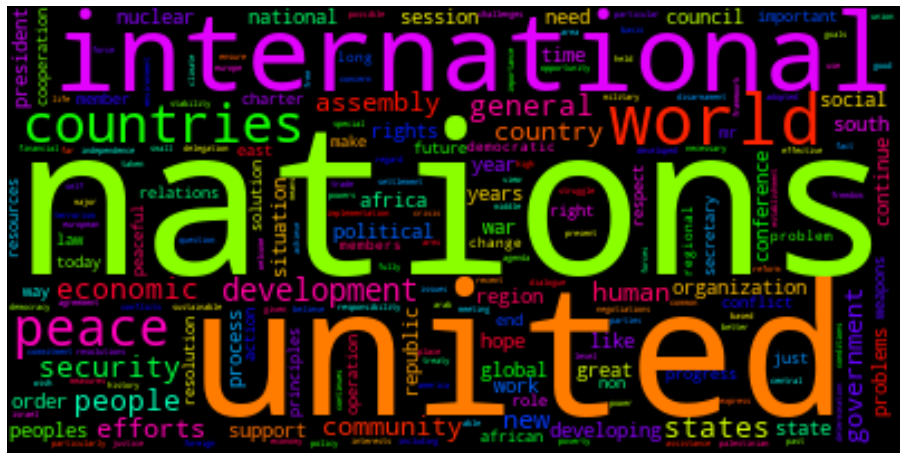

In [70]:
cloud = WordCloud(max_font_size=100, background_color="black", colormap="hsv").generate_from_frequencies(a)

plt.figure(figsize=(16,12))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

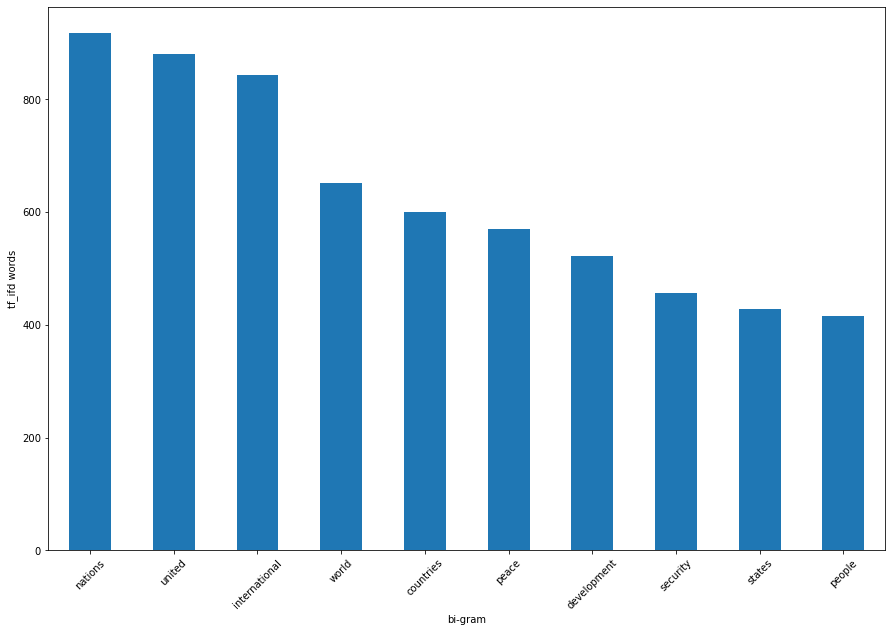

In [48]:
plt.figure(figsize=(15,10))
a[0:10].plot.bar()
plt.xticks(rotation=45)
plt.xlabel("word")
plt.ylabel("amount of words")
plt.title("10 most used words")
plt.show()

In [66]:
df_un_merged.loc[:,'ALB',:]

,Session,Speech,Country or Area
Year,,,
1970,25,33: may i first convey to our president the co...,Albania
1971,26,110.\t this session of the general assembly i...,Albania
1972,27,"first, may i, mr. president, express to you th...",Albania
1973,28,"﻿86.\tmr. president, on behalf of the people's...",Albania
1974,29,"mr. president, i wish first of all, on behalf ...",Albania
1975,30,"128.\t allow me, mr. president, to extend to y...",Albania
1976,31,"first of all, mr. president, i should like on ...",Albania
1977,32,﻿134.\t may i congratulate mr. mojsov on his e...,Albania
1978,33,"﻿25.\tallow me first to congratulate you, sir,...",Albania


In [6]:
df_un_merged.reset_index()

,Year,ISO-alpha3 Code,Session,Speech,Country or Area
0,1970,LBR,25,"49.\t it gives me great pleasure, mr. presiden...",Liberia
1,1970,TTO,25,"135.\t before commencing my statement, i shou...",Trinidad and Tobago
2,1970,KWT,25,"1.\t mr. president, your election to the aug...",Kuwait
3,1970,SOM,25,107.\t it is with great pleasure that my deleg...,Somalia
4,1970,SDN,25,126.\t in this anniversary year the general as...,Sudan
...,...,...,...,...,...
8476,2020,SLB,75,"mr. president,\non behalf of my government and...",Solomon Islands
8477,2020,POR,75,"mr. chairman of the general assembly,\nmr. sec...",NaN
8478,2020,MDG,75,"mister president,\nexcellencies ladies and gen...",Madagascar
8479,2020,PRY,75,"president of the general assembly,\nexcellenci...",Paraguay


## Merge UNGDC with bag of words

In [7]:
df_un_merged = df_un_merged.reset_index().merge(X_counts, how='left', left_index=True, right_index=True)
df_un_merged.set_index(['Year','ISO-alpha3 Code'], inplace=True)


## Read happiness report and merge with country codes to get ISO-alpha3 Code

In [8]:
happinessdataframe = pd.read_excel('DataForTable2.1.xls')
df_happiness_merged = happinessdataframe.merge(df_codes[['Country or Area','ISO-alpha3 Code']], how='left', left_on='Country name', right_on='Country or Area')
df_happiness_merged.set_index(['year','ISO-alpha3 Code'], inplace=True)
df_happiness_merged.index.rename(['Year','ISO-alpha3 Code'], inplace=True)
df_happiness_merged.drop(columns=['Country name','Country or Area'], inplace=True)

## Merge UNGDC with happiness report by Multiple index Year, ISO

In [9]:
df_un_merged = df_un_merged.merge(df_happiness_merged, how='left', left_index=True, right_index=True)

## Build Regression for Life Ladder

### remove NaN rows from Life Ladder

In [10]:
# remove na from rows
x=df_un_merged.dropna(subset=['Life Ladder'])

### Split data set

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline


y = x['Life Ladder'].values

# splitting the data
x_rem, x_test, y_rem, y_test = train_test_split(x, y, test_size=0.3, random_state = 42)
x_train, x_valid, y_train, y_valid = train_test_split(x_rem, y_rem, test_size=0.3, random_state = 42)






### Hyperparameters tunning based grid search on validation data set

In [12]:
# Create grid of parameters to test through cross-validation
param_grid = {'polynomialfeatures__degree': np.arange(1,3)}

pipe = make_pipeline( PolynomialFeatures(), LinearRegression())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(x_valid[words_list], y_valid);


/home/wolfson/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/home/wolfson/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/wolfson/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 390, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/wolfson/anaconda3/lib/python3.9/site-packages/sklearn/pipeline.py", line 348, in _fit
    X, fitted_transformer = fit_transform_one_cach

### Fit the best estimator on train set

In [13]:
grid.best_estimator_.fit(x_train[words_list], y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=1)),
                ('linearregression', LinearRegression())])

In [14]:
y_pred = grid.best_estimator_.predict(x_test[words_list])


# Compute test error and variance score
print("Model accuracy:")
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print('Variance score: %.2f' % r2_score(y_test, y_pred))
print("")

Model accuracy:
Mean squared error: 0.32
Variance score: 0.72



In [15]:
 set(x_test.reset_index()['ISO-alpha3 Code'])

{'AFG',
 'AGO',
 'ALB',
 'ARE',
 'ARG',
 'ARM',
 'AUS',
 'AUT',
 'AZE',
 'BDI',
 'BEL',
 'BEN',
 'BFA',
 'BGD',
 'BGR',
 'BHR',
 'BIH',
 'BLR',
 'BRA',
 'BTN',
 'BWA',
 'CAN',
 'CHE',
 'CHL',
 'CHN',
 'CMR',
 'COL',
 'CRI',
 'CYP',
 'CZE',
 'DEU',
 'DNK',
 'DZA',
 'ECU',
 'EGY',
 'ESP',
 'EST',
 'ETH',
 'FIN',
 'FRA',
 'GAB',
 'GEO',
 'GHA',
 'GIN',
 'GRC',
 'GTM',
 'HND',
 'HRV',
 'HTI',
 'HUN',
 'IDN',
 'IND',
 'IRL',
 'IRQ',
 'ISL',
 'ISR',
 'ITA',
 'JAM',
 'JOR',
 'JPN',
 'KAZ',
 'KEN',
 'KGZ',
 'KHM',
 'KWT',
 'LBN',
 'LBR',
 'LBY',
 'LKA',
 'LSO',
 'LTU',
 'LUX',
 'LVA',
 'MAR',
 'MDG',
 'MEX',
 'MKD',
 'MLI',
 'MLT',
 'MMR',
 'MNE',
 'MNG',
 'MOZ',
 'MRT',
 'MUS',
 'MWI',
 'MYS',
 'NAM',
 'NER',
 'NGA',
 'NIC',
 'NLD',
 'NOR',
 'NPL',
 'NZL',
 'PAK',
 'PAN',
 'PER',
 'PHL',
 'POL',
 'PRT',
 'PRY',
 'QAT',
 'ROU',
 'RWA',
 'SDN',
 'SEN',
 'SGP',
 'SLE',
 'SLV',
 'SOM',
 'SRB',
 'SUR',
 'SVK',
 'SVN',
 'SWE',
 'SWZ',
 'TCD',
 'TGO',
 'THA',
 'TJK',
 'TKM',
 'TTO',
 'TUN',
 'UGA',


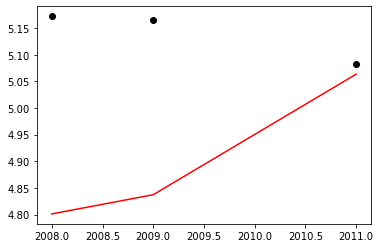

In [16]:
a = words_list.tolist()
a.append('Life Ladder')
data = x_test.loc[:,'UKR',:][a].reset_index()
y_pred_country = grid.best_estimator_.predict(data[words_list])

fig, ax = plt.subplots()
ax.scatter(data['Year'],data['Life Ladder'], c='black')
ax.plot(data['Year'],y_pred_country, c='red')

In [17]:
# Create grid of parameters to test through cross-validation
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
param_grid = {'max_depth': [10,50, 100, 200, 300]}
grid_forest = GridSearchCV(RandomForestRegressor(), param_grid, cv=5)
grid_forest.fit(x_valid, y_valid);

/home/wolfson/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
25 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/wolfson/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/wolfson/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 327, in fit
    X, y = self._validate_data(
  File "/home/wolfson/anaconda3/lib/python3.9/site-packages/sklearn/base.py", line 581, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  Fil

ValueError: could not convert string to float: 'allow me at the outset to congratulate mr. kerim most \nwarmly on his outstanding election to the presidency of \nthe general assembly at its sixty-second session. we \nare convinced that his professional qualities and his \nvast and rich academic, diplomatic and business \nexperience will lead to the success of our work. i \ntherefore assure him of my delegation’s fullest support \nin the discharge of his mandate. \n with respect to outgoing president sheikha haya \nrashed al-khalifa, i wish to express our great \nsatisfaction at her dynamic and skilful handling of the \nwork of the previous session. \n as to the secretary-general, i take this \nopportunity to reiterate the niger government’s \nadmiration and encouragement on his assumption of \nthe leadership of our collective organization. \n two years after the 2005 world summit, which \ngave our leaders an opportunity to address the \nchallenges and threats confronting humankind, we \ncannot help feeling optimistic   despite the \npersistence of such scourges as international terrorism \nor the slow progress towards fulfilling the millennium \ndevelopment goals   as we consider the unflagging \nwillingness of the international community resolutely \nto seek solutions consonant with the threats that have \nbeen identified. \n in the field of international peace and security, \none element of the significant developments in certain \nparts of the world is, without a doubt, the positive \nimpact of the peacebuilding commission, in particular \nin burundi and sierra leone. that alone makes the \ncreation of that new body worthwhile. in africa, such \npositive and encouraging trends can be witnessed in \nthe hope raised by developments in certain conflict \nareas.  \n in west africa, liberia continues to move ahead \nwith national reconstruction and consolidation of \npeace.  \n in côte d’ivoire, the peace process has shown \ngreat promise since the ouagadougou agreement was \nsigned in march 2007 and a “flame of peace” \nceremony took place. those two major events bear \nwitness to the parties’ will to put a permanent end to \nthe crisis that exploded in that country five years ago.  \n sierra leone, for the first time, and after a long \nperiod of instability, has organized free and transparent \nlegislative and presidential elections, bearing witness \nto the resolve of the suffering people of that country to \nmove beyond tragedy and to resolutely build a bright \nfuture.  \n in central africa, the adoption by the great \nlakes countries of the pact on security, stability and \ndevelopment leads us to expect, in the medium term, a \nmeaningful improvement in the troubled situation that \nhas prevailed there for some years now. it is \nencouraging to note that burundi is already at the point \nwhere it can do without the international community’s \nsupervision in peacekeeping efforts within its borders \nand to devote itself fully to the task of economic and \nsocial development.  \n the democratic republic of the congo is another \ncase in which we will allow ourselves to have great \nhopes if all the parties join in the peace movement and \ntake part in the ongoing democratic process.  \n in darfur, the situation remains worrisome to be \nsure, but thanks to the agreement between the \ngovernment of the sudan and the united nations and \nthe adoption of security council resolution 1769 \n(2007) on 31 july, we hope that there will soon be a \nreturn to peace and security in that part of the sudan.  \n in western sahara, we are gratified by the \ninitiation of direct negotiations between morocco and \nthe polisario front, including the two meetings \nheld under the aegis of the personal envoy of the \nsecretary-general subsequent to the adoption of \nsecurity council resolution 1754 (2007).  \n finally, with regard to somalia, we earnestly \nhope that the national reconciliation conference and the \nefforts of the international community will yield \npositive results and enable that brother country to \nemerge forever from the crisis that has prevailed there \nfor years. \n the situation in the middle east, dominated by \nthe israel-palestine conflict, requires more focused \nattention by the international community. my \ndelegation feels that the resumption of the political \nprocess remains the only way to move towards a just \nand lasting solution, on the basis of the relevant united \nnations resolutions and the principle of two viable \nstates living side by side in peace and security. the \nquartet road map and the arab peace initiative remain \nframes of reference in this regard.  \n generally speaking, the coherent subregional \napproach employed by the united nations and the \nsubregional organizations seems well suited to \nhandling conflicts, and also to responding to other \nconcerns, such as international migration, trafficking in \nhuman beings, trafficking in drugs, transnational crime \nand the proliferation and spread of small arms and light \nweapons. from this perspective, in particular as \nregards the african continent, the capacity of \nsubregional organizations and the african union \nshould be reinforced.  \n the united nations ten-year capacity-building \nprogramme for the african union is to be commended, \nas it opens new possibilities for conflict prevention and \nthe maintenance of lasting peace on the continent, in \nparticular through the creation of an african \nintervention force. along these lines, the open debates \nof the security council on strengthening the role of the \ncouncil in conflict prevention and resolution, in \nparticular in africa, are of great importance.  \n conflicts are not the only threats to international \npeace and security. other phenomena, sometimes more \ndevastating and unforeseeable, threaten the ability of \npeoples around the world to enjoy their legitimate right \nto peace and security. those phenomena include \ninternational terrorism, transnational crime and all \ntypes of trafficking.  \n in this connection, the sahara, a geographical \nzone that the niger shares with several other african \ncountries, is becoming a den of drug and arms \ntraffickers, fuelling and perpetuating insecurity in the \nregion. the niger intends to participate intensively in \nany effort to enhance the international community’s \nefforts to eradicate that scourge, which undermines the \neconomies of the countries concerned and threatens the \nfoundations of democracy.  \n in that regard, my delegation considers \ninternational cooperation and assistance for affected \ndeveloping countries to be indispensable if we are to \nsucceed in combating drug trafficking and trafficking \nin small arms and light weapons, including anti-tank \nand anti-personnel mines. these are used by armed \ngroups to continue to inflict untold suffering on \ninnocent civilians, obstruct trade and hinder all \ndevelopment activities in infested areas. the scope and \ngravity of the phenomenon truly require that the \ninternational community give it all due attention and \nfirmly condemn the criminal acts being carried out by \nthese networks of traffickers, in particular in our \nregion. \n the linkage between peace, security, \ndevelopment and human rights, spelled out in the 2005 \nworld summit outcome (resolution 60/1), has lost \nnone of its relevance and continues to fuel our \nthinking. that is why the niger continues to feel a \nsense of solidarity for all initiatives, present or future, \ndesigned to give new momentum to development \nefforts.  \n niger welcomes the initiative of the informal \nthematic debate entitled “partnerships towards \nachieving the millennium development goals: taking \nstock, moving forward”, held on 27 november 2006 \nand the first in a series of three debates organized by \nthe general assembly in the context of its \nrevitalization process. on that occasion, some \ndevelopment partners were able to undertake concrete \ncommitments, such as that of the islamic development \nbank, which announced the creation of a poverty \nmitigation fund endowed with a $10 billion budget. \nthe government of the niger, through me, would like \nto commend that exemplary initiative, which is part of \nan ever more effective development partnership.  \n the niger sees the general assembly’s adoption \nof resolution of 61/16 on strengthening the role of the \neconomic and social council as a great step forward. \nthe resolution names the economic and social council \nas a principal body responsible for economic and social \ndevelopment and, in particular, for the implementation \nof the international development goals agreed at the \nmajor united nations conferences and summits, \nincluding the millennium development goals.  \n we congratulate the state of qatar on having \nhosted the preparatory meeting for the monterrey \nconsensus review conference, to be held in doha in \n2008. moreover, the unparalleled commitment of the \ngovernment of qatar to international development led \nit to host the conference on consolidating food \nsecurity in niger, which was held in doha with the \nsupport of the organization of the islamic conference \nand proved most successful. i therefore take this \nprivileged moment at the rostrum of the general \nassembly at its sixty-second session to reiterate the \nprofound gratitude of the people and government of \nthe niger to that friendly country, the entire islamic \nummah and all other partners who kindly supported \nthat initiative. \n the international community should pay \nparticular attention to one category of countries that is \neven more vulnerable. i am referring to land-locked \ndeveloping countries, whose geography puts them at a \ngreat disadvantage. in 2003, the almaty conference, \nhaving considered their situation, adopted a \ndeclaration and programme of action, the \nimplementation of which is soon to be reviewed. the \ntime has therefore come to launch an urgent appeal to \nall development partners to resolve to take the \nnecessary measures not only to help those countries to \nachieve the millennium development goals, but also \nto enable them to mitigate the negative impacts of \ndesertification, environmental degradation and climate \nchange.  \n desertification and the deteriorating environment \nare two problems that seriously affect the countries of \nthe sahel, including mine. the combined efforts of the \ninternational community effectively to combat those \nscourges should be stepped up. the action taken by the \nniger, based on the experience gained through the \nspecial programme launched by the president of the \nrepublic, has allowed us to achieve spectacular \nsuccesses that deserve to be consolidated and \nstrengthened. \n thanks to the work to restore degraded soil, \nremove sand and reforest the landscape undertaken \nover the past few years and stepped up in the \nframework of that programme, 3 million hectares have \nbeen reclaimed from the desert, according to satellite \nmonitoring undertaken in 2006 and transmitted by the \nregional agrimet centre. large expanses that were \ndesperately arid have now become productive  \nagricultural areas and pasture land thanks to water-\nretention and infiltration activities that have raised the \nwater table. it is worth noting that such activities are \nbeing carried out by several thousand young people \nbeing paid through a cash-for-work programme.  \n the public debate in the security council and the \nthematic debate in the general assembly dedicated to \nclimate change highlighted the scope and gravity of the \nphenomenon by emphasizing the need for urgent \ncollective action. the eloquent statements made at the \nhigh-level meeting organized by the secretary-general \non 24 september lead us to believe that the parties are \nwilling to move to achieve essential objectives, which \nis the only way to secure a wholesome and reliable \nenvironment for present and future generations. the \nniger resolutely supports that momentum and, within \nits national strategy and plan of action for climate \nchange and viability, has drafted a national programme \nof action for adaptation to climate change. \n all such questions, which fall within the context \nof a comprehensive vision of sustainable development, \nare covered in our revised poverty reduction strategy, \nwhich is the reference framework for my country’s \noverall economic and development policy. i take this \nexceptional opportunity solemnly to invite all our \ndevelopment partners to participate in the international \nconference on the niger’s revised poverty reduction \nstrategy, to be held in brussels in october. the \nconference has been called, inter alia, to harmonize and \ncoordinate the contributions of our development \npartners. \n harmonization and coordination are topical \nissues in the united nations. they are essential to \nincreasing the organization’s effectiveness in \ncollective action to address global challenges and \nthreats. my delegation agrees that system-wide \ncoherence in united nations activities should be a \nprincipal focus for the implementation of reforms \nadvocated in the outcome document of the 2005 \nworld summit. we must therefore find the means to \nimplement them. i note that we see such reforms as a \nway of better helping developing countries to achieve \nlasting economic growth, develop sustainably and \neradicate poverty.  \n that is the vision that leads me to reaffirm the \nniger’s conviction that coherence and coordination \nmust be inspired by the cardinal principles of \nownership, national leadership and respect for national \ndevelopment priorities. \n'

In [ ]:
y_pred = grid_forest.best_estimator_.predict(x_test)
grid_forest.best_estimator_
# Compute test error and variance score
print("Model accuracy:")
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print('Variance score: %.2f' % r2_score(y_test, y_pred))
print("")
fig, ax = plt.subplots()
ax.scatter(np.arange(0,len(y_test)),y_test, c='black')
ax.scatter(np.arange(0,len(y_pred)),y_pred, c='red')
plt.show()

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
reg = GradientBoostingRegressor(random_state=0)
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)

# Compute test error and variance score
print("Model accuracy:")
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print('Variance score: %.2f' % r2_score(y_test, y_pred))
print("")
fig, ax = plt.subplots()
ax.scatter(np.arange(0,len(y_test)),y_test, c='black')
ax.scatter(np.arange(0,len(y_pred)),y_pred, c='red')
plt.show()